## IN this notebook we seek to make improvements in the BLEU and ROUGE score 

* what we found out? 
    * ROUGE and BLEU even with more and more reference text produce erratic results and are not worth measuring, atleast as it seems at the minute. 
    * we move our attention  to answer relevancy and context relevancy which are measured with cosine similarity and other metrics. 


The question: Tell me about the battle of Boyne in 100 words

Metrics for Response_experiment1_llama2:
BLEU Score: 0.05081462365238676
ROUGE Scores: {'rouge1': Score(precision=0.2, recall=0.7083333333333334, fmeasure=0.3119266055045872), 'rouge2': Score(precision=0.09523809523809523, recall=0.34782608695652173, fmeasure=0.14953271028037382), 'rougeL': Score(precision=0.12941176470588237, recall=0.4583333333333333, fmeasure=0.2018348623853211)}
TER Score: 353.48837209302326
Cosine Similarities: [0.2845662  0.37635072]

Metrics for Response_experiment1_mistral:
BLEU Score: 1.802838347877723e-78
ROUGE Scores: {'rouge1': Score(precision=0.18181818181818182, recall=0.75, fmeasure=0.2926829268292683), 'rouge2': Score(precision=0.07142857142857142, recall=0.30434782608695654, fmeasure=0.11570247933884298), 'rougeL': Score(precision=0.1111111111111111, recall=0.4583333333333333, fmeasure=0.17886178861788618)}
TER Score: 404.6511627906977
Cosine Similarities: [0.34242308 0.45899219]

Metrics fo

/opt/homebrew/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


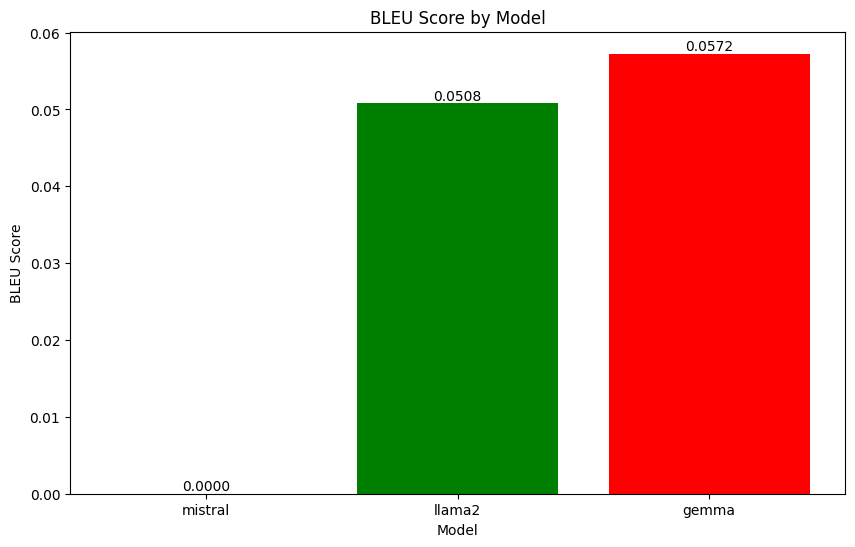

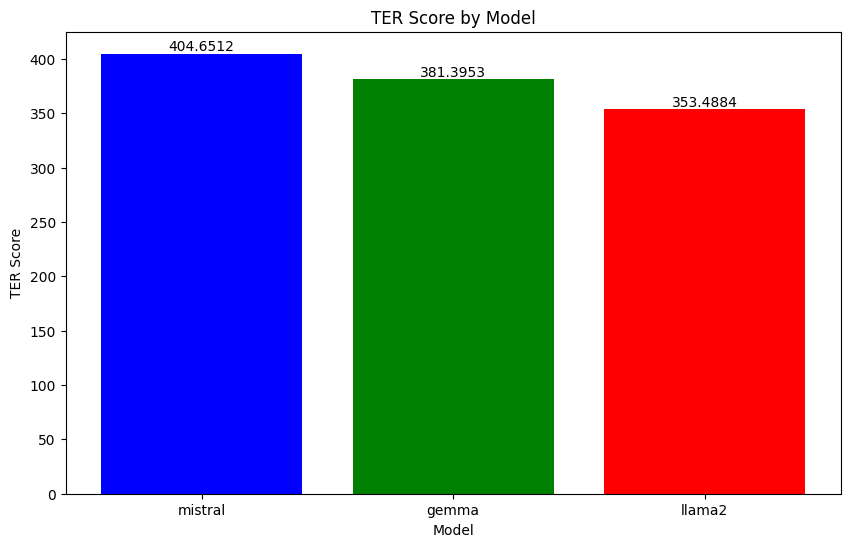

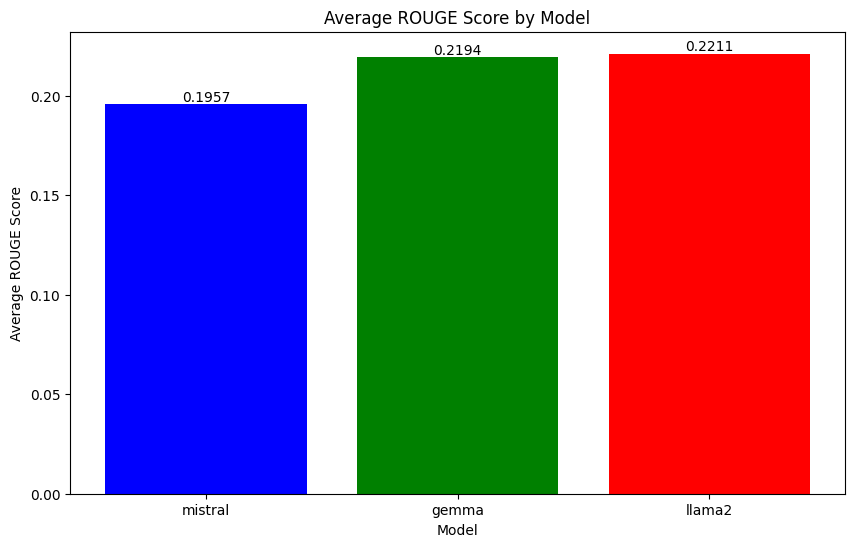

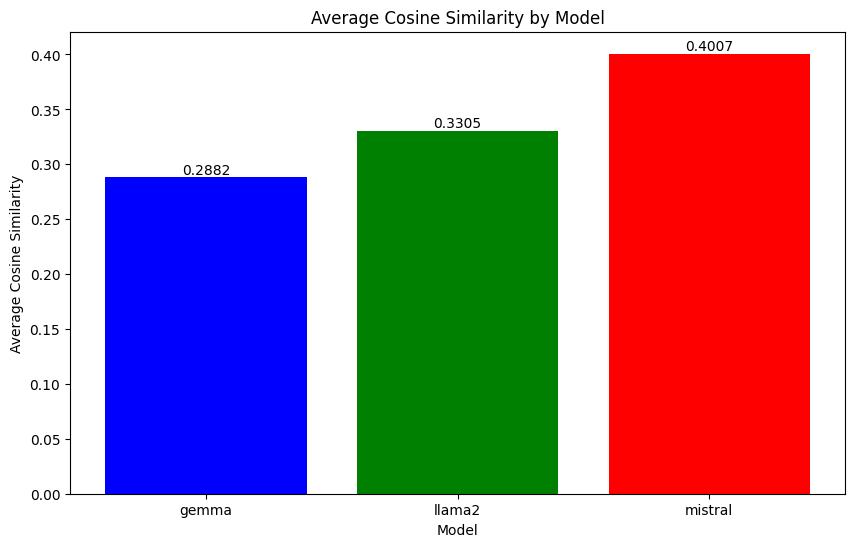

In [3]:
import time
from llama_index.llms.ollama import Ollama
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sacrebleu import corpus_ter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Responses dictionary to store model responses
responses = {}

# Metrics dictionary to store all the metrics
metrics3C = {}

# Experiments list detailing the models and the question
experiments = [
    {'experiment_number': 1, 'model_choice': 'llama2', 'question': "Tell me about the battle of Boyne in 100 words"},
    {'experiment_number': 1, 'model_choice': 'mistral', 'question': "Tell me about the battle of Boyne in 100 words"},
    {'experiment_number': 1, 'model_choice': 'gemma', 'question': "Tell me about the battle of Boyne in 100 words"},
]

print(f"The question: {experiments[1]['question']}\n")

# Processing each experiment
for experiment in experiments:
    llm = Ollama(model=experiment['model_choice'], request_timeout=30.0)
    start_time = time.time()
    response = llm.complete(experiment['question'],
                            temperature=0.00001,  # Adjust for desired randomness
                            seed=42)
    end_time = time.time()

    response_key = f"Response_experiment{experiment['experiment_number']}_{experiment['model_choice']}"
    responses[response_key] = response.text

# Reference responses for evaluation
reference_responses = [
    "The Battle of Boyne, occurring in 1690, was a pivotal event in Irish history, marking a decisive victory for William III over James II.",
    "In 1690, the Battle of Boyne saw William III defeat James II, significantly impacting the political landscape of Ireland."
]

# Evaluation of NLP metrics for each response
for key, llm_response in responses.items():
    # Initialize a nested dictionary for this response
    metrics3C[key] = {}
    
    # Calculate BLEU score
    bleu_score = sentence_bleu([ref.split() for ref in reference_responses], llm_response.split())
    metrics3C[key]['BLEU Score'] = bleu_score

    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_score = scorer.score(reference_responses[0], llm_response)
    metrics3C[key]['ROUGE Scores'] = rouge_score

    # Calculate TER score
    ter_score = corpus_ter([llm_response], [[ref] for ref in reference_responses]).score
    metrics3C[key]['TER Score'] = ter_score

    # Calculate Cosine Similarities
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform([llm_response] + reference_responses)
    cosine_similarities = cosine_similarity(tfidf[0:1], tfidf[1:])
    metrics3C[key]['Cosine Similarities'] = cosine_similarities.flatten()
    
    print(f"Metrics for {key}:")
    print(f"BLEU Score: {bleu_score}")
    print(f"ROUGE Scores: {rouge_score}")
    print(f"TER Score: {ter_score}")
    print(f"Cosine Similarities: {cosine_similarities.flatten()}\n")

# Extracting and preparing data for visualization
visualization_data = {
    'BLEU Score': {},
    'TER Score': {},
    'Average ROUGE Score': {},
    'Average Cosine Similarity': {}
}

for key, values in metrics3C.items():
    model_name = key.split('_')[-1]  # Extracting model name from the key
    visualization_data['BLEU Score'][model_name] = values['BLEU Score']
    visualization_data['TER Score'][model_name] = values['TER Score']
    # Calculating average ROUGE score 
    average_rouge_score = np.mean([score.fmeasure for score in values['ROUGE Scores'].values()])
    visualization_data['Average ROUGE Score'][model_name] = average_rouge_score
    # Average Cosine Similarity
    average_cosine_similarity = np.mean(values['Cosine Similarities'])
    visualization_data['Average Cosine Similarity'][model_name] = average_cosine_similarity


def plot_results(metric_name, results_dict, ascending=True):
    # Sort results based on value
    sorted_results = sorted(results_dict.items(), key=lambda x: x[1], reverse=not ascending)
    
    models = [x[0] for x in sorted_results]
    scores = [x[1] for x in sorted_results]
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(models, scores, color=['blue', 'green', 'red'])
    plt.title(f'{metric_name} by Model')
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    plt.xticks(models)
    
    # Show the exact value on top of each bar
    for i, score in enumerate(scores):
        plt.text(i, score, f"{score:.4f}", ha = 'center', va = 'bottom')

    plt.show()

# Plot each metric
for metric_name, results_dict in visualization_data.items():
    if metric_name == 'TER Score':
        plot_results(metric_name, results_dict, ascending=False)  # Lower TER Score is better, hence reverse sorting
    else:
        plot_results(metric_name, results_dict)



In [4]:
## Now putting the right reference to create a more correct ROUGE score  

The question: Tell me about the battle of Boyne in 100 words

Metrics for Response_experiment1_llama2:
BLEU Score: 0.11971718330309739
ROUGE Scores: {'rouge1': Score(precision=0.6666666666666666, recall=0.4915254237288136, fmeasure=0.5658536585365854), 'rouge2': Score(precision=0.26744186046511625, recall=0.19658119658119658, fmeasure=0.22660098522167485), 'rougeL': Score(precision=0.39080459770114945, recall=0.288135593220339, fmeasure=0.33170731707317075)}
TER Score: 72.64957264957265
Cosine Similarities: [0.72416764]

Metrics for Response_experiment1_mistral:
BLEU Score: 0.0992310909746883
ROUGE Scores: {'rouge1': Score(precision=0.6095238095238096, recall=0.5423728813559322, fmeasure=0.5739910313901346), 'rouge2': Score(precision=0.22115384615384615, recall=0.19658119658119658, fmeasure=0.2081447963800905), 'rougeL': Score(precision=0.37142857142857144, recall=0.3305084745762712, fmeasure=0.34977578475336324)}
TER Score: 75.21367521367522
Cosine Similarities: [0.72799675]



/opt/homebrew/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Metrics for Response_experiment1_gemma:
BLEU Score: 1.6411764714141961e-78
ROUGE Scores: {'rouge1': Score(precision=0.5657894736842105, recall=0.3644067796610169, fmeasure=0.44329896907216493), 'rouge2': Score(precision=0.2, recall=0.1282051282051282, fmeasure=0.15625), 'rougeL': Score(precision=0.35526315789473684, recall=0.2288135593220339, fmeasure=0.27835051546391754)}
TER Score: 79.48717948717949
Cosine Similarities: [0.62232108]



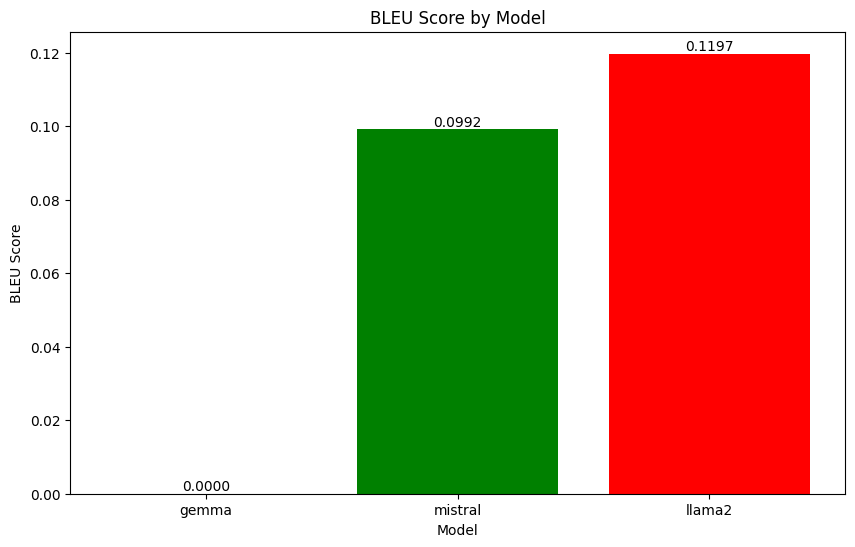

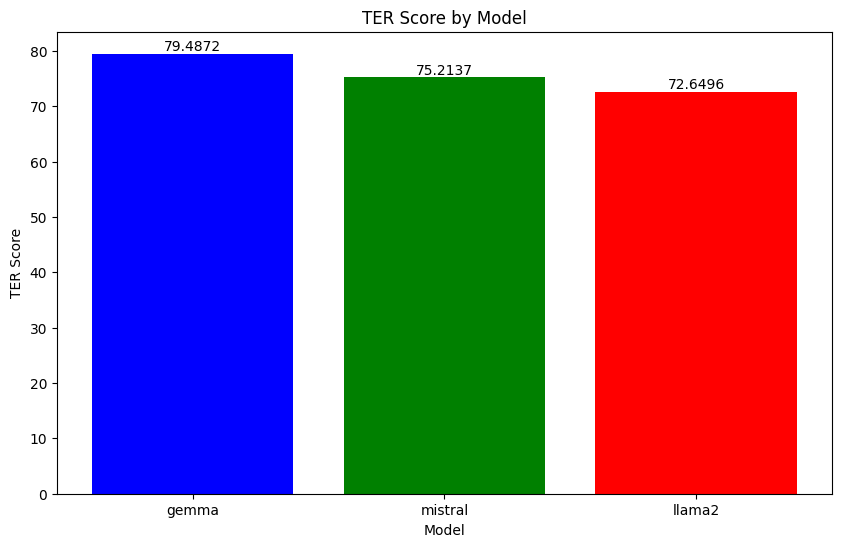

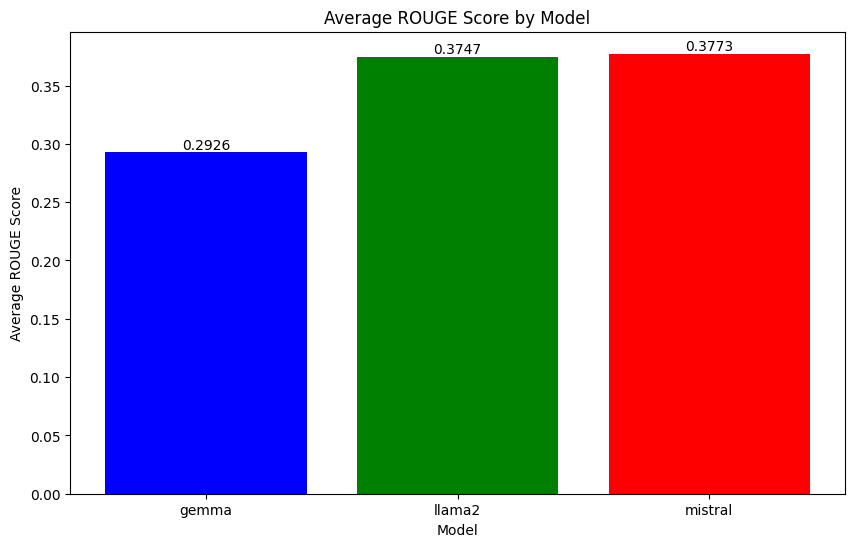

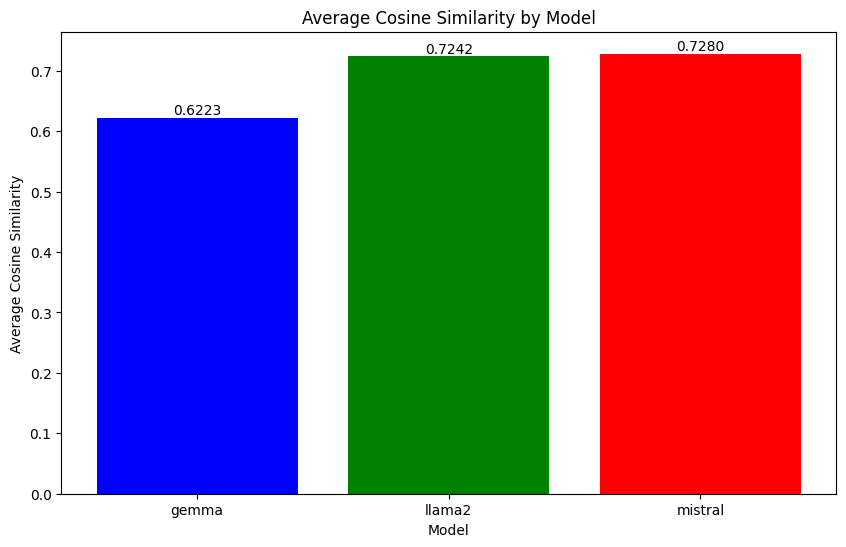

In [5]:
GPT4_reference = "The Battle of the Boyne, fought on July 1, 1690, near the River Boyne in Ireland, was a pivotal moment in Irish, British, and European history. This conflict was between the deposed King James II of England and Scotland, who had the support of Catholic France, and the Dutch Prince William of Orange, who had ascended to the English throne. William's victory ensured the continued Protestant ascendancy in Ireland. The battle is celebrated for its impact on maintaining Protestant power in England and has deep cultural significance, particularly in Northern Ireland, symbolizing the triumph of Protestantism. Engaging thousands of troops, it was more than a mere military engagement; it shaped the course of British and Irish history."


import time
from llama_index.llms.ollama import Ollama
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sacrebleu import corpus_ter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Responses dictionary to store model responses
responses = {}

# Metrics dictionary to store all the metrics
metrics3C = {}

# Experiments list detailing the models and the question
experiments = [
    {'experiment_number': 1, 'model_choice': 'llama2', 'question': "Tell me about the battle of Boyne in 100 words"},
    {'experiment_number': 1, 'model_choice': 'mistral', 'question': "Tell me about the battle of Boyne in 100 words"},
    {'experiment_number': 1, 'model_choice': 'gemma', 'question': "Tell me about the battle of Boyne in 100 words"},
]

print(f"The question: {experiments[1]['question']}\n")

# Processing each experiment
for experiment in experiments:
    llm = Ollama(model=experiment['model_choice'], request_timeout=30.0)
    start_time = time.time()
    response = llm.complete(experiment['question'],
                            temperature=0.00001,  # Adjust for desired randomness
                            seed=42)
    end_time = time.time()

    response_key = f"Response_experiment{experiment['experiment_number']}_{experiment['model_choice']}"
    responses[response_key] = response.text

# Reference responses for evaluation
reference_responses = [
    "The Battle of the Boyne, fought on July 1, 1690, near the River Boyne in Ireland, was a pivotal moment in Irish, British, and European history. This conflict was between the deposed King James II of England and Scotland, who had the support of Catholic France, and the Dutch Prince William of Orange, who had ascended to the English throne. William's victory ensured the continued Protestant ascendancy in Ireland. The battle is celebrated for its impact on maintaining Protestant power in England and has deep cultural significance, particularly in Northern Ireland, symbolizing the triumph of Protestantism. Engaging thousands of troops, it was more than a mere military engagement; it shaped the course of British and Irish history."
]


# Evaluation of NLP metrics for each response
for key, llm_response in responses.items():
    # Initialize a nested dictionary for this response
    metrics3C[key] = {}
    
    # Calculate BLEU score
    bleu_score = sentence_bleu([ref.split() for ref in reference_responses], llm_response.split())
    metrics3C[key]['BLEU Score'] = bleu_score

    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_score = scorer.score(reference_responses[0], llm_response)
    metrics3C[key]['ROUGE Scores'] = rouge_score

    # Calculate TER score
    ter_score = corpus_ter([llm_response], [[ref] for ref in reference_responses]).score
    metrics3C[key]['TER Score'] = ter_score

    # Calculate Cosine Similarities
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform([llm_response] + reference_responses)
    cosine_similarities = cosine_similarity(tfidf[0:1], tfidf[1:])
    metrics3C[key]['Cosine Similarities'] = cosine_similarities.flatten()
    
    print(f"Metrics for {key}:")
    print(f"BLEU Score: {bleu_score}")
    print(f"ROUGE Scores: {rouge_score}")
    print(f"TER Score: {ter_score}")
    print(f"Cosine Similarities: {cosine_similarities.flatten()}\n")

# Extracting and preparing data for visualization
visualization_data = {
    'BLEU Score': {},
    'TER Score': {},
    'Average ROUGE Score': {},
    'Average Cosine Similarity': {}
}

for key, values in metrics3C.items():
    model_name = key.split('_')[-1]  # Extracting model name from the key
    visualization_data['BLEU Score'][model_name] = values['BLEU Score']
    visualization_data['TER Score'][model_name] = values['TER Score']
    # Calculating average ROUGE score 
    average_rouge_score = np.mean([score.fmeasure for score in values['ROUGE Scores'].values()])
    visualization_data['Average ROUGE Score'][model_name] = average_rouge_score
    # Average Cosine Similarity
    average_cosine_similarity = np.mean(values['Cosine Similarities'])
    visualization_data['Average Cosine Similarity'][model_name] = average_cosine_similarity


def plot_results(metric_name, results_dict, ascending=True):
    # Sort results based on value
    sorted_results = sorted(results_dict.items(), key=lambda x: x[1], reverse=not ascending)
    
    models = [x[0] for x in sorted_results]
    scores = [x[1] for x in sorted_results]
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(models, scores, color=['blue', 'green', 'red'])
    plt.title(f'{metric_name} by Model')
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    plt.xticks(models)
    
    # Show the exact value on top of each bar
    for i, score in enumerate(scores):
        plt.text(i, score, f"{score:.4f}", ha = 'center', va = 'bottom')

    plt.show()

# Plot each metric
for metric_name, results_dict in visualization_data.items():
    if metric_name == 'TER Score':
        plot_results(metric_name, results_dict, ascending=False)  # Lower TER Score is better, hence reverse sorting
    else:
        plot_results(metric_name, results_dict)



The question: Tell me about the battle of Boyne in 100 words

Metrics for Response_experiment1_llama2:
BLEU Score: 0.052868804524527815
ROUGE Scores: {'rouge1': Score(precision=0.6419753086419753, recall=0.37142857142857144, fmeasure=0.47058823529411764), 'rouge2': Score(precision=0.2, recall=0.11510791366906475, fmeasure=0.14611872146118723), 'rougeL': Score(precision=0.38271604938271603, recall=0.22142857142857142, fmeasure=0.28054298642533937)}
TER Score: 83.7037037037037
Cosine Similarities: [0.64626207]

Metrics for Response_experiment1_mistral:
BLEU Score: 0.06914267321181058
ROUGE Scores: {'rouge1': Score(precision=0.5841584158415841, recall=0.42142857142857143, fmeasure=0.48962655601659755), 'rouge2': Score(precision=0.13, recall=0.09352517985611511, fmeasure=0.1087866108786611), 'rougeL': Score(precision=0.3069306930693069, recall=0.22142857142857142, fmeasure=0.2572614107883818)}
TER Score: 82.22222222222221
Cosine Similarities: [0.62380613]

Metrics for Response_experiment1_

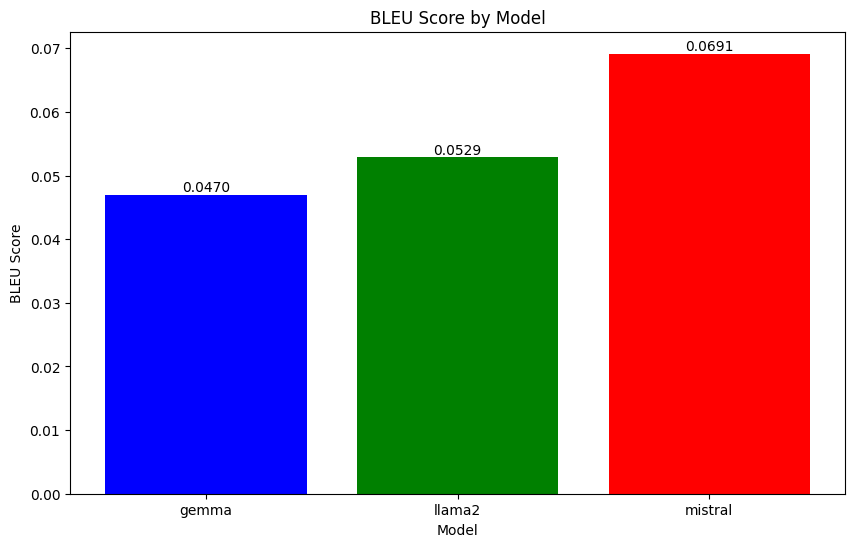

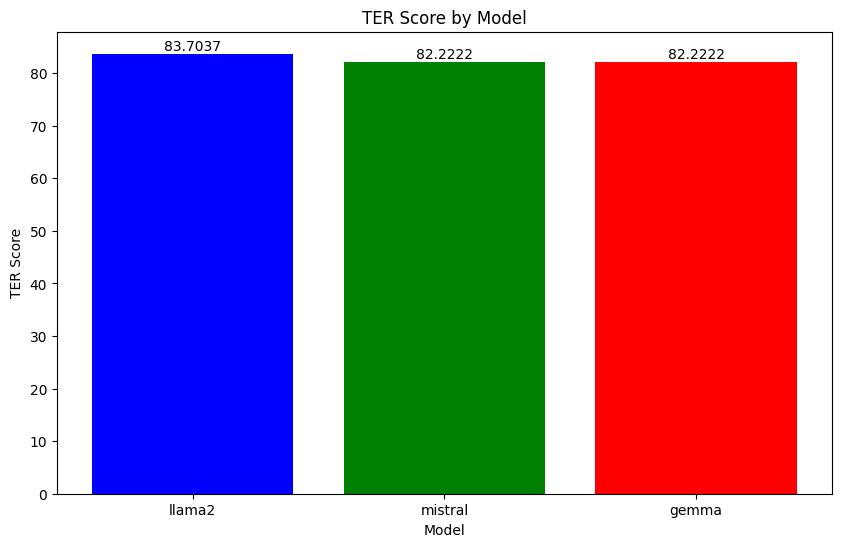

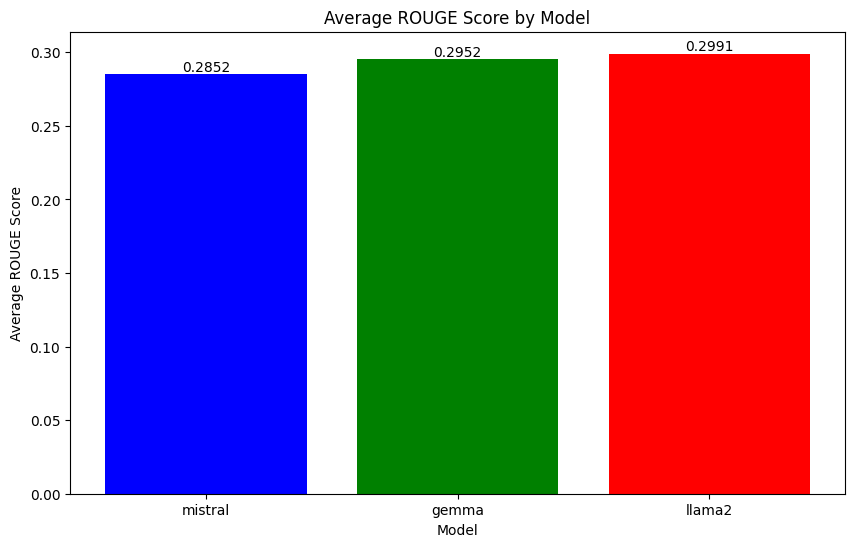

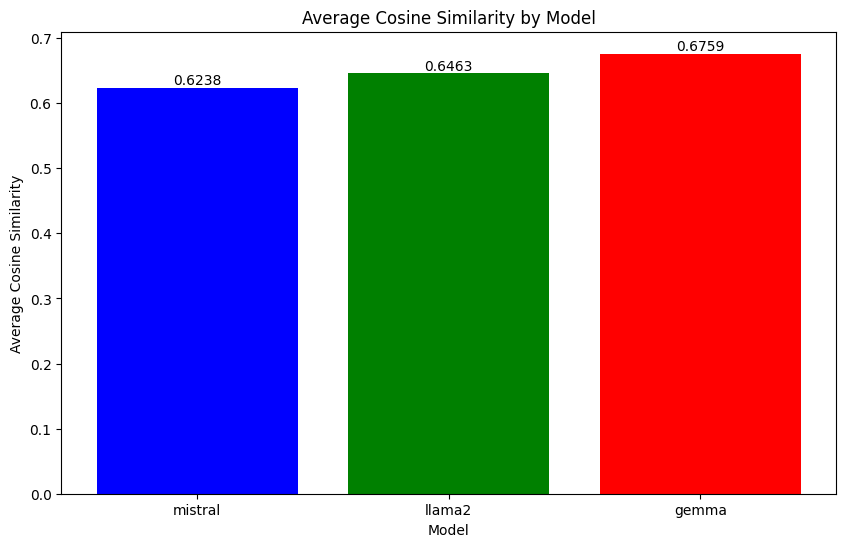

In [7]:
GPT4_reference = "The Battle of the Boyne, fought on July 1, 1690, near the River Boyne in Ireland, was a pivotal moment in Irish, British, and European history. This conflict was between the deposed King James II of England and Scotland, who had the support of Catholic France, and the Dutch Prince William of Orange, who had ascended to the English throne. William's victory ensured the continued Protestant ascendancy in Ireland. The battle is celebrated for its impact on maintaining Protestant power in England and has deep cultural significance, particularly in Northern Ireland, symbolizing the triumph of Protestantism. Engaging thousands of troops, it was more than a mere military engagement; it shaped the course of British and Irish history."


import time
from llama_index.llms.ollama import Ollama
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sacrebleu import corpus_ter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Responses dictionary to store model responses
responses = {}

# Metrics dictionary to store all the metrics
metrics3C = {}

# Experiments list detailing the models and the question
experiments = [
    {'experiment_number': 1, 'model_choice': 'llama2', 'question': "Tell me about the battle of Boyne in 100 words"},
    {'experiment_number': 1, 'model_choice': 'mistral', 'question': "Tell me about the battle of Boyne in 100 words"},
    {'experiment_number': 1, 'model_choice': 'gemma', 'question': "Tell me about the battle of Boyne in 100 words"},
]

print(f"The question: {experiments[1]['question']}\n")

# Processing each experiment
for experiment in experiments:
    llm = Ollama(model=experiment['model_choice'], request_timeout=30.0)
    start_time = time.time()
    response = llm.complete(experiment['question'],
                            temperature=0.00001,  # Adjust for desired randomness
                            seed=42)
    end_time = time.time()

    response_key = f"Response_experiment{experiment['experiment_number']}_{experiment['model_choice']}"
    responses[response_key] = response.text

# Reference responses for evaluation
    ## This contains the summarisation of text of wikipedia made  by gpt4 
reference_responses = [
    "The Battle of the Boyne, a crucial event in 1690, marked a significant clash between the forces of the deposed King James II and King William III, alongside Queen Mary II. This battle, integral to James's efforts to reclaim the English and Scottish thrones, was influenced by broader European geopolitical tensions involving major powers like France and the Papal States. Fought near Drogheda, Ireland, William's victory decisively ended James's campaign, contributing to the Protestant ascendancy in Ireland. The conflict, embedded in sectarian and ethnic strife, echoed past Irish Confederate Wars, with underlying issues of sovereignty, religious freedom, and land ownership at stake. James's loss led to his final exile in France, despite the Jacobite control over Ireland and the support from a majority of the Irish population, fueled by promises of religious tolerance and self-determination."
]


# Evaluation of NLP metrics for each response
for key, llm_response in responses.items():
    # Initialize a nested dictionary for this response
    metrics3C[key] = {}
    
    # Calculate BLEU score
    bleu_score = sentence_bleu([ref.split() for ref in reference_responses], llm_response.split())
    metrics3C[key]['BLEU Score'] = bleu_score

    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_score = scorer.score(reference_responses[0], llm_response)
    metrics3C[key]['ROUGE Scores'] = rouge_score

    # Calculate TER score
    ter_score = corpus_ter([llm_response], [[ref] for ref in reference_responses]).score
    metrics3C[key]['TER Score'] = ter_score

    # Calculate Cosine Similarities
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform([llm_response] + reference_responses)
    cosine_similarities = cosine_similarity(tfidf[0:1], tfidf[1:])
    metrics3C[key]['Cosine Similarities'] = cosine_similarities.flatten()
    
    print(f"Metrics for {key}:")
    print(f"BLEU Score: {bleu_score}")
    print(f"ROUGE Scores: {rouge_score}")
    print(f"TER Score: {ter_score}")
    print(f"Cosine Similarities: {cosine_similarities.flatten()}\n")

# Extracting and preparing data for visualization
visualization_data = {
    'BLEU Score': {},
    'TER Score': {},
    'Average ROUGE Score': {},
    'Average Cosine Similarity': {}
}

for key, values in metrics3C.items():
    model_name = key.split('_')[-1]  # Extracting model name from the key
    visualization_data['BLEU Score'][model_name] = values['BLEU Score']
    visualization_data['TER Score'][model_name] = values['TER Score']
    # Calculating average ROUGE score 
    average_rouge_score = np.mean([score.fmeasure for score in values['ROUGE Scores'].values()])
    visualization_data['Average ROUGE Score'][model_name] = average_rouge_score
    # Average Cosine Similarity
    average_cosine_similarity = np.mean(values['Cosine Similarities'])
    visualization_data['Average Cosine Similarity'][model_name] = average_cosine_similarity


def plot_results(metric_name, results_dict, ascending=True):
    # Sort results based on value
    sorted_results = sorted(results_dict.items(), key=lambda x: x[1], reverse=not ascending)
    
    models = [x[0] for x in sorted_results]
    scores = [x[1] for x in sorted_results]
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(models, scores, color=['blue', 'green', 'red'])
    plt.title(f'{metric_name} by Model')
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    plt.xticks(models)
    
    # Show the exact value on top of each bar
    for i, score in enumerate(scores):
        plt.text(i, score, f"{score:.4f}", ha = 'center', va = 'bottom')

    plt.show()

# Plot each metric
for metric_name, results_dict in visualization_data.items():
    if metric_name == 'TER Score':
        plot_results(metric_name, results_dict, ascending=False)  # Lower TER Score is better, hence reverse sorting
    else:
        plot_results(metric_name, results_dict)



Note: you may need to restart the kernel to use updated packages.


In [12]:
from llama_index.llms.ollama import Ollama
from transformers import AutoTokenizer, AutoModel
import torch
from scipy.spatial.distance import cdist

# Initialize Ollama with Mistral model
ollama = Ollama(model="mistral", request_timeout=30.0)

# Define the prompt and generate a response
prompt = "Tell me about the Battle of Boyne in 100 words"
response = ollama.complete(prompt)  # Ensure this call is correct based on your setup

# Load reference texts
model_responses = [response.text]
reference_texts = ["The Battle of the Boyne, a crucial event in 1690, marked a significant clash between the forces of the deposed King James II and King William III, alongside Queen Mary II. This battle, integral to James's efforts to reclaim the English and Scottish thrones, was influenced by broader European geopolitical tensions involving major powers like France and the Papal States. Fought near Drogheda, Ireland, William's victory decisively ended James's campaign, contributing to the Protestant ascendancy in Ireland. The conflict, embedded in sectarian and ethnic strife, echoed past Irish Confederate Wars, with underlying issues of sovereignty, religious freedom, and land ownership at stake. James's loss led to his final exile in France, despite the Jacobite control over Ireland and the support from a majority of the Irish population, fueled by promises of religious tolerance and self-determination."]


# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Function to get embeddings, unchanged
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()  # Direct conversion to numpy and moving tensor out of GPU if necessary

# Generate embeddings for responses and references
# Directly convert to numpy to avoid stacking issues
response_embeddings_np = np.array([get_embedding(response) for response in model_responses])
reference_embeddings_np = np.array([get_embedding(reference) for reference in reference_texts])

# Ensure 2D shape for 'cdist'
# 'response_embeddings_np' and 'reference_embeddings_np' should already be 2D but let's ensure and check
print(f"Response Embeddings Shape: {response_embeddings_np.shape}")
print(f"Reference Embeddings Shape: {reference_embeddings_np.shape}")

# Calculate cosine similarity
similarities = 1 - cdist(response_embeddings_np.reshape(len(model_responses), -1), 
                         reference_embeddings_np.reshape(len(reference_texts), -1), 'cosine')

# Display Results
for i, response in enumerate(model_responses):
    print(f"Response {i+1}:")
    for j, reference in enumerate(reference_texts):
        print(f"\tReference {j+1}: {similarities[i][j]:.3f}")

Response Embeddings Shape: (1, 1, 384)
Reference Embeddings Shape: (1, 1, 384)
Response 1:
	Reference 1: 0.807


## Performance of Semantic similarity using different metrics such as manhattan similarity and other metrics 

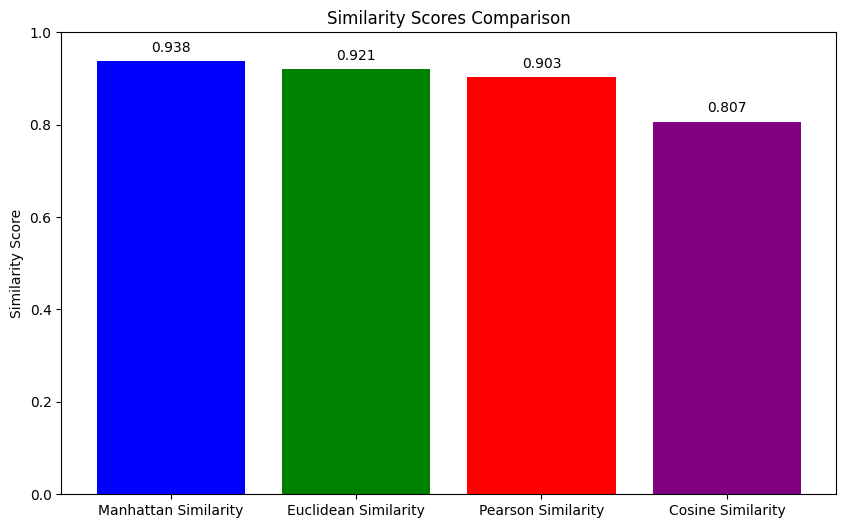

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean, cityblock

# Assuming the embeddings are already generated as per your previous code

# Helper function to normalize distances to a similarity score in [0, 1]
def normalize_distance(dist, max_dist=None):
    if max_dist is not None:
        return 1 - (dist / max_dist)
    return 1 / (1 + dist)

# Calculate Euclidean and Manhattan distances and Pearson correlation
euclidean_dist = euclidean(response_embeddings_np.flatten(), reference_embeddings_np.flatten())
manhattan_dist = cityblock(response_embeddings_np.flatten(), reference_embeddings_np.flatten())

# For Pearson, we calculate correlation and p-value, then take the correlation
pearson_corr, _ = pearsonr(response_embeddings_np.flatten(), reference_embeddings_np.flatten())
# Normalize Pearson correlation from [-1, 1] to [0, 1]
pearson_similarity = (pearson_corr + 1) / 2

# Assuming 'similarities' contains the cosine similarity as calculated previously
cosine_similarity = similarities[0][0]

# Normalize Euclidean and Manhattan distances based on an assumed max distance for visualization purposes
# You might want to adjust max distances based on your data range
max_euclidean = np.linalg.norm(np.ones_like(response_embeddings_np.flatten()))
max_manhattan = len(response_embeddings_np.flatten())

euclidean_similarity = normalize_distance(euclidean_dist, max_dist=max_euclidean)
manhattan_similarity = normalize_distance(manhattan_dist, max_dist=max_manhattan)

# Collecting all similarity scores for plotting
similarity_scores = {
    'Cosine Similarity': cosine_similarity,
    'Euclidean Similarity': euclidean_similarity,
    'Manhattan Similarity': manhattan_similarity,
    'Pearson Similarity': pearson_similarity
}

# Sorting scores for descending order plotting
sorted_scores = sorted(similarity_scores.items(), key=lambda item: item[1], reverse=True)

# Plotting
labels, scores = zip(*sorted_scores)  # Unpacking the sorted items into labels and scores

plt.figure(figsize=(10, 6))
plt.bar(labels, scores, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Similarity Scores Comparison')
plt.ylabel('Similarity Score')
for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.3f}", ha='center')  # Display the score above each bar for clarity

plt.show()


### Above gives some score, making sense of it 
* the above was reference context relevancy using Semantic similarity  -> generated response compare and referred against reference text using cosine similarity 
* above rather than being semantic search is a semantic similarity eval -> generates embeddings for both responses and reference, comparing the cosine similarity between both is then compared. 


* semantic search is more applicable for tests where knowledge based answers are to be tested, they will be now in a new RAG doc index. 

* 

In [19]:
from bert_score import score
from llama_index.llms.ollama import Ollama

# Initialize Ollama with Mistral model
ollama = Ollama(model="mistral", request_timeout=30.0)

# Define the prompt and generate a response
prompt = "Tell me about the Battle of Boyne in 100 words"
response = ollama.complete(prompt)

# Load reference texts
model_responses = [response.text]
reference_texts = ["The Battle of the Boyne, fought on July 1, 1690, near the River Boyne in Ireland, was a pivotal moment in Irish, British, and European history. This conflict was between the deposed King James II of England and Scotland, who had the support of Catholic France, and the Dutch Prince William of Orange, who had ascended to the English throne. William's victory ensured the continued Protestant ascendancy in Ireland. The battle is celebrated for its impact on maintaining Protestant power in England and has deep cultural significance, particularly in Northern Ireland, symbolizing the triumph of Protestantism. Engaging thousands of troops, it was more than a mere military engagement; it shaped the course of British and Irish history."]  # Truncated for brevity

# Calculate BERTscore
P, R, F1 = score(model_responses, reference_texts, lang="en", verbose=True, model_type="distilbert-base-uncased")

# Display BERTScore
for i in range(len(model_responses)):
    print(f"Response {i+1}:")
    print(f"\tPrecision: {P[i].item():.3f}")
    print(f"\tRecall: {R[i].item():.3f}")
    print(f"\tF1 Score: {F1[i].item():.3f}")


tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 45.8kB/s]
config.json: 100%|██████████| 483/483 [00:00<00:00, 1.62MB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 12.9MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 12.7MB/s]
model.safetensors: 100%|██████████| 268M/268M [00:39<00:00, 6.79MB/s] 


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 130.82it/s]

done in 0.07 seconds, 15.10 sentences/sec
Response 1:
	Precision: 0.859
	Recall: 0.838
	F1 Score: 0.848


# Parallel running 

In [20]:
import pandas as pd

data = {
    "Question": [
        "What were the consequences of Oppenheimer's personal conflicts and legal challenges on his professional life?",
        "How did the public perception of Oppenheimer change after the atomic bombings of Hiroshima and Nagasaki?",
        "What was Truman's response to Oppenheimer's concerns about the atomic bomb and its implications?",
        "How did Strauss's actions contribute to Oppenheimer's security clearance issues?",
        "What role did Lewis Strauss play in the post-war atomic policy and Oppenheimer's career?",
        "What were the effects of the H-bomb development on Oppenheimer's stance on nuclear weapons?",
        "How did Oppenheimer's past affiliations and actions become a point of contention during the security hearings?",
        "What was the impact of the atomic bomb on Oppenheimer's personal reflections and public statements?",
        "In what ways did Oppenheimer attempt to influence US atomic policy after the war?",
        "How did the security hearing against Oppenheimer unfold and what were the strategies used by Strauss?"
    ],
    "Answer": [
        "Oppenheimer's legal challenges and personal conflicts, particularly with figures like Lewis Strauss, significantly affected his professional life, leading to the loss of his security clearance and damaging his credibility and influence in national security matters.",
        "After the atomic bombings, Oppenheimer became known as the 'father of the atomic bomb', a title that brought him fame but also led to public and personal turmoil over the ethical implications of his work.",
        "Truman dismissed Oppenheimer's concerns about the atomic bomb and its implications for an arms race with the Soviets, emphasizing the bomb's role in ending World War II and suggesting that concerns over international cooperation and arms control were misplaced.",
        "Strauss played a crucial role in the revocation of Oppenheimer's security clearance, leveraging past associations and controversies to challenge Oppenheimer's credibility and influence in atomic policy.",
        "Lewis Strauss's influence extended beyond Oppenheimer's security clearance issues, affecting post-war atomic policy and contributing to the tension between military objectives and scientific ethical considerations.",
        "The development of the H-bomb and the associated policy decisions deepened Oppenheimer's concerns about nuclear weapons, leading him to advocate for arms control and to question the direction of US atomic policy.",
        "Oppenheimer's past affiliations with communist and leftist groups became a focal point during his security hearings, overshadowing his contributions to the Manhattan Project and contributing to the revocation of his security clearance.",
        "The atomic bomb had a profound impact on Oppenheimer's personal reflections and public statements, leading him to express remorse and to advocate for nuclear disarmament and international cooperation.",
        "Oppenheimer attempted to influence US atomic policy by advocating for international control of atomic energy and arms control, efforts that were ultimately overshadowed by the Cold War context and his own security clearance controversy.",
        "The security hearing against Oppenheimer was characterized by strategic maneuvers by Strauss and others, who used the hearings to systematically undermine Oppenheimer's credibility and to isolate him from the policy-making process."
    ]
}

# Create the DataFrame
OppenheimerQA = pd.DataFrame(data)
OppenheimerQA
OppenheimerQA_verbose = OppenheimerQA
data_updated = {
    "Question": data["Question"],
    "Answer": [
        "The professional trajectory of J. Robert Oppenheimer was significantly affected by his personal conflicts and legal challenges, particularly those with Lewis Strauss. These conflicts led to a high-profile security clearance hearing that scrutinized Oppenheimer's affiliations and actions. The eventual loss of his security clearance diminished his influence in nuclear policy discussions and tarnished his reputation, highlighting the impact of political loyalty and scientific freedom conflicts.",
        "Following the atomic bombings of Hiroshima and Nagasaki, Oppenheimer became known as the 'father of the atomic bomb', a title that brought him fame but also public and personal turmoil over the ethical implications of his work. His image transitioned from a leading physicist to a symbol of the moral dilemmas of nuclear weapons, reflecting on the complexities of scientific innovation, moral responsibility, and public perception in the aftermath of such a monumental event.",
        "President Harry S. Truman's response to Oppenheimer's concerns about the atomic bomb and its implications for an arms race with the Soviets was dismissive, emphasizing the bomb's strategic advantages. This conversation reflects a pivotal moment in nuclear policy history, where the chance for disarmament and international control of atomic energy was overlooked in favor of maintaining strategic superiority, underscoring the challenges of advocating for nuclear restraint post-World War II.",
        "Lewis Strauss played a crucial role in Oppenheimer's security clearance issues, leveraging suspicions and controversies to initiate a review. This was part of a broader effort to marginalize Oppenheimer from nuclear policy advisory roles, demonstrating the politicization of security clearances and how personal and ideological differences could impact the careers of key scientific figures in the atomic age.",
        "Strauss significantly influenced post-war atomic policy and Oppenheimer's career, representing interests that favored military considerations over scientific ethics. His campaign against Oppenheimer marked a decisive shift in U.S. atomic policy towards aggressive nuclear arms development, reflecting the broader ideological battle over atomic energy control and the tension between scientific and military priorities.",
        "The H-bomb's development and the shift in atomic policy profoundly affected Oppenheimer's stance on nuclear weapons. He became an advocate for arms control, highlighting the ethical dilemmas and global destruction potential of nuclear arms. This shift illustrates the challenges faced by scientists involved in nuclear technology development, emphasizing the ethical and policy implications of their work in the context of Cold War tensions.",
        "Oppenheimer's past affiliations with leftist and communist groups became focal points during his security hearings, overshadowing his contributions to the Manhattan Project. This scrutiny under Cold War paranoia cast doubts on his loyalty, revealing the era's fears and the impact of political ideologies on scientific communities.",
        "The atomic bomb's development and use had a profound impact on Oppenheimer's personal reflections and public statements, leading him to advocate for nuclear disarmament and international cooperation. This period of his life underscores the moral and ethical concerns associated with nuclear weapons and the responsibility of those who develop such technologies.",
        "Oppenheimer attempted to influence U.S. atomic policy towards disarmament and international control post-war, despite the Cold War's influence overshadowing these efforts. His advocacy for nuclear restraint highlights the complexities of policy-making in the atomic age, emphasizing the need for transparency, ethical consideration, and international cooperation in nuclear matters.",
        "The security hearing against Oppenheimer, characterized by Strauss's strategic maneuvers, systematically undermined his credibility and isolated him from policy-making. This episode illustrates the use of political tactics in security hearings and the broader implications for governance, policy direction, and the role of individuals in shaping national security agendas."
    ]
}

# Creating the updated DataFrame
OppenheimerQA_verbose = pd.DataFrame(data_updated)
OppenheimerQA_verbose

,Question,Answer
0,What were the consequences of Oppenheimer's pe...,The professional trajectory of J. Robert Oppen...
1,How did the public perception of Oppenheimer c...,Following the atomic bombings of Hiroshima and...
2,What was Truman's response to Oppenheimer's co...,President Harry S. Truman's response to Oppenh...
3,How did Strauss's actions contribute to Oppenh...,Lewis Strauss played a crucial role in Oppenhe...
4,What role did Lewis Strauss play in the post-w...,Strauss significantly influenced post-war atom...
5,What were the effects of the H-bomb developmen...,The H-bomb's development and the shift in atom...
6,How did Oppenheimer's past affiliations and ac...,Oppenheimer's past affiliations with leftist a...
7,What was the impact of the atomic bomb on Oppe...,The atomic bomb's development and use had a pr...
8,In what ways did Oppenheimer attempt to influe...,Oppenheimer attempted to influence U.S. atomic...
9,How did the security hearing against Oppenheim...,"The security hearing against Oppenheimer, char..."


The question: What were the consequences of Oppenheimer's personal conflicts and legal challenges on his professional life?

Metrics for Response_experiment1_llama2:
BLEU Score: 0.024091583580419566
ROUGE Scores: {'rouge1': Score(precision=0.10804597701149425, recall=0.7014925373134329, fmeasure=0.18725099601593628), 'rouge2': Score(precision=0.03686635944700461, recall=0.24242424242424243, fmeasure=0.064), 'rougeL': Score(precision=0.07126436781609195, recall=0.4626865671641791, fmeasure=0.12350597609561753)}
TER Score: 604.6153846153846
Cosine Similarities: [0.60490812]

Metrics for Response_experiment1_mistral:
BLEU Score: 0.0217354840595196
ROUGE Scores: {'rouge1': Score(precision=0.1652542372881356, recall=0.582089552238806, fmeasure=0.25742574257425743), 'rouge2': Score(precision=0.03829787234042553, recall=0.13636363636363635, fmeasure=0.059800664451827246), 'rougeL': Score(precision=0.1059322033898305, recall=0.373134328358209, fmeasure=0.165016501650165)}
TER Score: 329.230769

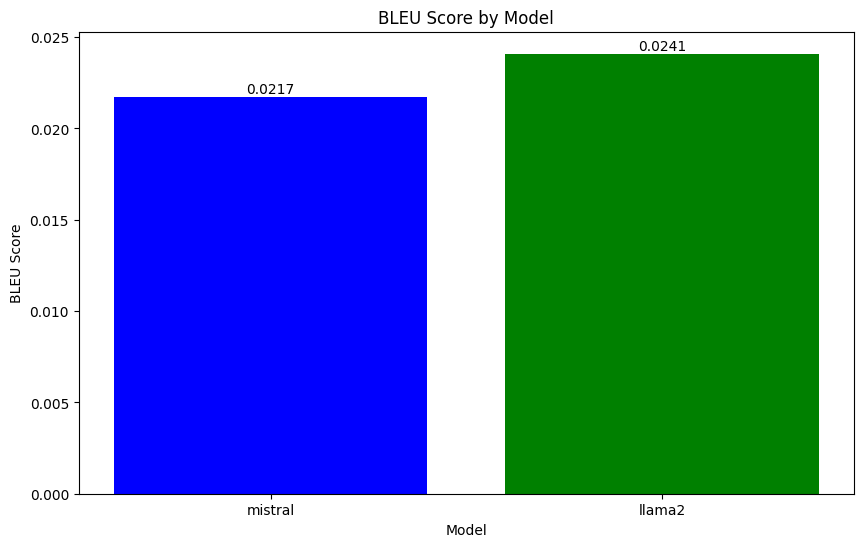

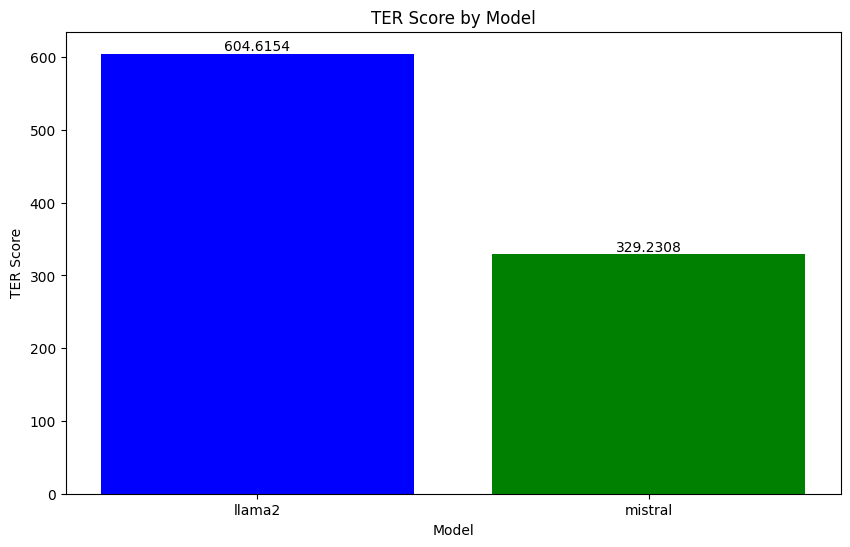

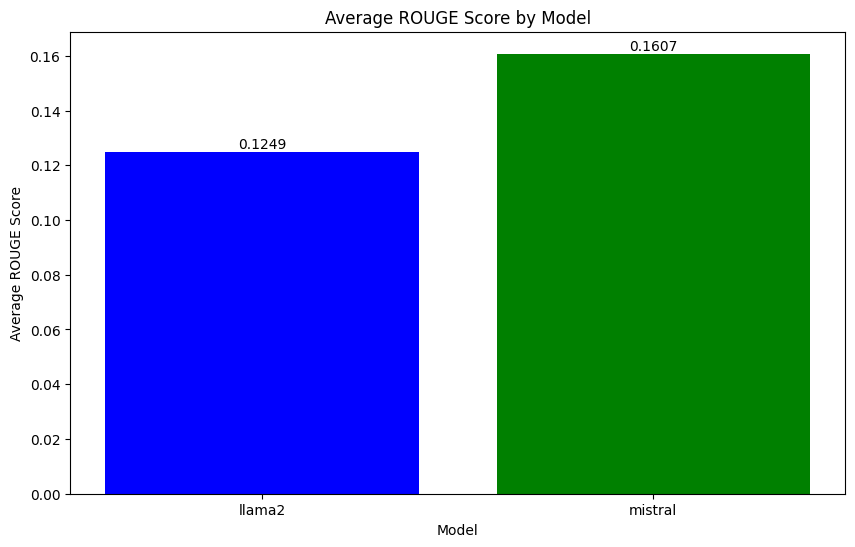

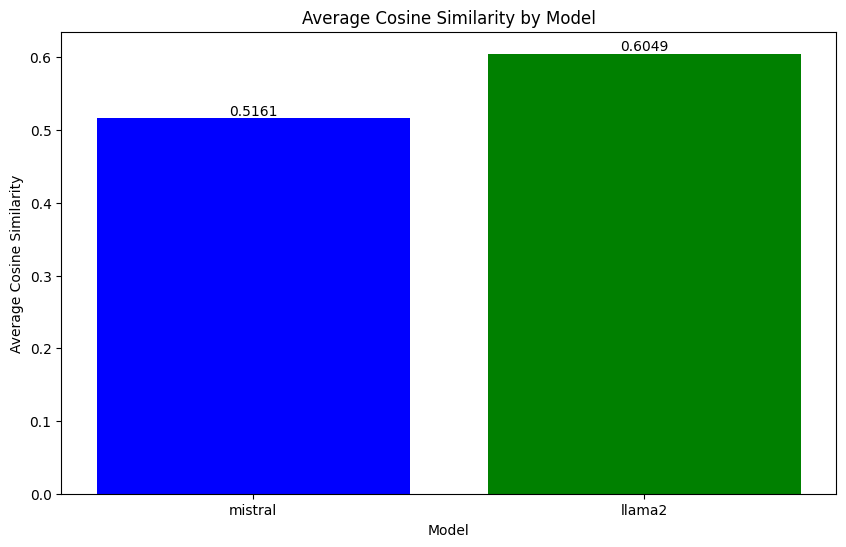

In [24]:
GPT4_reference = OppenheimerQA_verbose["Answer"][0]

import time
from llama_index.llms.ollama import Ollama
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sacrebleu import corpus_ter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

responses = {}
metrics3C = {}

experiments = [
    {'experiment_number': 1, 'model_choice': 'llama2', 'question': OppenheimerQA_verbose['Question'][0]},
    {'experiment_number': 1, 'model_choice': 'mistral', 'question':OppenheimerQA_verbose['Question'][0]},
]

print(f"The question: {experiments[0]['question']}\n")

for experiment in experiments:
    llm = Ollama(model=experiment['model_choice'], request_timeout=30.0)
    start_time = time.time()
    response = llm.complete(experiment['question'],
                            temperature=0.00001,  
                            seed=42)
    end_time = time.time()

    response_key = f"Response_experiment{experiment['experiment_number']}_{experiment['model_choice']}"
    responses[response_key] = response.text

reference_responses = [GPT4_reference]

for key, llm_response in responses.items():
    metrics3C[key] = {}
    bleu_score = sentence_bleu([ref.split() for ref in reference_responses], llm_response.split())
    metrics3C[key]['BLEU Score'] = bleu_score
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_score = scorer.score(reference_responses[0], llm_response)
    metrics3C[key]['ROUGE Scores'] = rouge_score
    ter_score = corpus_ter([llm_response], [[ref] for ref in reference_responses]).score
    metrics3C[key]['TER Score'] = ter_score
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform([llm_response] + reference_responses)
    cosine_similarities = cosine_similarity(tfidf[0:1], tfidf[1:])
    metrics3C[key]['Cosine Similarities'] = cosine_similarities.flatten()
    
    print(f"Metrics for {key}:")
    print(f"BLEU Score: {bleu_score}")
    print(f"ROUGE Scores: {rouge_score}")
    print(f"TER Score: {ter_score}")
    print(f"Cosine Similarities: {cosine_similarities.flatten()}\n")

visualization_data = {
    'BLEU Score': {},
    'TER Score': {},
    'Average ROUGE Score': {},
    'Average Cosine Similarity': {}
}

for key, values in metrics3C.items():
    model_name = key.split('_')[-1]
    visualization_data['BLEU Score'][model_name] = values['BLEU Score']
    visualization_data['TER Score'][model_name] = values['TER Score']
    average_rouge_score = np.mean([score.fmeasure for score in values['ROUGE Scores'].values()])
    visualization_data['Average ROUGE Score'][model_name] = average_rouge_score
    average_cosine_similarity = np.mean(values['Cosine Similarities'])
    visualization_data['Average Cosine Similarity'][model_name] = average_cosine_similarity

def plot_results(metric_name, results_dict, ascending=True):
    sorted_results = sorted(results_dict.items(), key=lambda x: x[1], reverse=not ascending)
    models = [x[0] for x in sorted_results]
    scores = [x[1] for x in sorted_results]
    plt.figure(figsize=(10, 6))
    plt.bar(models, scores, color=['blue', 'green'])
    plt.title(f'{metric_name} by Model')
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    plt.xticks(models)
    for i, score in enumerate(scores):
        plt.text(i, score, f"{score:.4f}", ha = 'center', va = 'bottom')
    plt.show()

# Plot each metric
for metric_name, results_dict in visualization_data.items():
    if metric_name == 'TER Score':
        plot_results(metric_name, results_dict, ascending=False)  # Lower TER Score is better, hence reverse sorting
    else:
        plot_results(metric_name, results_dict)
